## *Transform in ETL*

In [278]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', category=FutureWarning)
warnings.simplefilter('ignore', category=ImportWarning)

In [279]:
# Load raw data
orders_full = pd.read_csv('data/raw_data.csv')

# *Transorm-Full*

## 1.*Data cleanning*

In [280]:
orders_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   order_id       100 non-null    int64  
 1   customer_name  99 non-null     object 
 2   product        100 non-null    object 
 3   quantity       74 non-null     float64
 4   unit_price     65 non-null     float64
 5   order_date     99 non-null     object 
 6   region         75 non-null     object 
dtypes: float64(2), int64(1), object(4)
memory usage: 5.6+ KB


### *Remove duplicates*

In [281]:
# Check for duplicates in the orders_full
orders_full.duplicated().sum()

1

In [282]:
# Remove duplicates
orders_full.drop_duplicates(inplace=True)

#### *Why and how*?

*`Action Taken`:* *Removed duplicate rows using `drop_duplicates()`.*

*`Reason`:Duplicate records can distort analysis, especially in aggregated reports such as total revenue or units sold. For example, if a transaction appears twice, it would double-count the quantity and revenue, leading to inaccurate business insights. Removing duplicates ensures data integrity and consistency before transformation or loading steps.*


####  *Handle missing values*

In [283]:
# Fill missing customer_name 'Unknown'
orders_full['customer_name'] = orders_full['customer_name'].fillna('Unknown')

In [284]:
#Fill missing order_date with a string placeholder
orders_full['order_date'] = orders_full['order_date'].fillna('2025-01-01')

In [285]:
# Fill missing region with 'Not Specified'
orders_full['region'] = orders_full['region'].fillna('Not Specified')

#### *Why and How*

*To ensure data completeness and maintain analysis integrity, the following transformations were applied to columns with missing values:*

---

#### *1. `customer_name`*  
*Action Taken:* *Filled with `"Unknown"`*  
*Reason:*  
*Customer name is a descriptive field and not directly used in calculations. Replacing the missing value with `"Unknown"` retains the row while clearly indicating the lack of customer information. This is a common practice in retail datasets where anonymous or guest customers may exist.*

---

#### *2. `order_date`*  
*Action Taken:* *Filled with placeholder `'2025-01-01'`, then converted to `datetime64`*  
*Reason:*  
*The `order_date` column is crucial for time-based analysis (e.g., trends, monthly summaries). Dropping the row would reduce the dataset, so a placeholder date was used to preserve it. The entire column was then converted to `datetime64[ns]` to support proper chronological sorting, filtering, and aggregation.*

---

#### *3. `region`*  
*Action Taken:* *Filled with `"Not Specified"`*  
*Reason:*  
*Although region is a categorical field, it’s important for geography-based reporting (e.g., revenue by region). Filling missing values with `"Not Specified"` helps retain the rows and provides a clear label that the location is unknown, without skewing results for actual regions.*

---


### *Contextual Imputation of Missing `unit_price` and `quantity` Values*

In [286]:
# Drop rows where both quantity and unit_price are missing
orders_full = orders_full.dropna(subset=['quantity', 'unit_price'], how='all')

In [287]:
# Convert order_date to datetime and extract month
orders_full['order_date'] = pd.to_datetime(orders_full['order_date'])
orders_full['month'] = orders_full['order_date'].dt.month

### *Apply Group-Based Imputation for Missing Values*

In [288]:
# Fill missing unit_price using mean of product, month, and region
orders_full['unit_price'] = orders_full.groupby(['product', 'month', 'region'])['unit_price'].transform(
    lambda x: x.fillna(x.mean())
)

#### *Broader Group for unit_price*

In [289]:
#Fill remaining missing unit_price by (product, month)
orders_full['unit_price'] = orders_full.groupby(['product', 'month'])['unit_price'].transform(
    lambda x: x.fillna(x.mean())
)

# Then fallback to (product) only
orders_full['unit_price'] = orders_full.groupby(['product'])['unit_price'].transform(
    lambda x: x.fillna(x.mean())
)

#### *Broader Group for quantity*

In [290]:
# Fill remaining missing quantity by (product, month)
orders_full['quantity'] = orders_full.groupby(['product', 'month'])['quantity'].transform(
    lambda x: x.fillna(x.median())
)

# Then fallback to (product) only
orders_full['quantity'] = orders_full.groupby(['product'])['quantity'].transform(
    lambda x: x.fillna(x.median())
)

#### *Why and How:Imputation of Missing `unit_price` and `quantity` Values*

*The `unit_price` and `quantity` columns are essential for sales analytics, as they are used to compute key metrics such as revenue and total units sold. Missing values in these fields would compromise the accuracy of downstream analysis.*

*To resolve this, a group-based imputation strategy was applied. Initially, the dataset was grouped by `product`, `region`, and `month` — representing logical business dimensions — and missing values were filled using:*

- *The **mean** of `unit_price` within each group.*
- *The **median** of `quantity` within each group.*

*However, due to the absence of sufficient historical records in some groupings, certain values remained missing. To ensure completeness, a fallback mechanism was implemented in the following sequence:*

1. *Group by `product` and `month`, and impute missing values.*
2. *If still missing, group by `product` alone and impute.*

*This tiered approach ensured all missing values were handled meaningfully without resorting to arbitrary global averages. It preserves the contextual integrity of the dataset and supports accurate and reliable transformation for further analysis.*


In [291]:
orders_full.info()


<class 'pandas.core.frame.DataFrame'>
Index: 91 entries, 0 to 99
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   order_id       91 non-null     int64         
 1   customer_name  91 non-null     object        
 2   product        91 non-null     object        
 3   quantity       91 non-null     float64       
 4   unit_price     91 non-null     float64       
 5   order_date     91 non-null     datetime64[ns]
 6   region         91 non-null     object        
 7   month          91 non-null     int32         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(1), object(3)
memory usage: 6.0+ KB


## *2.Structural Transformations & Data Type Conversion*

In [292]:
# Convert order_id to string/object type
orders_full['order_id'] = orders_full['order_id'].astype(str)

In [293]:
# Convert product and region to pandas 'category' dtype
orders_full['product'] = orders_full['product'].astype('category')
orders_full['region'] = orders_full['region'].astype('category')

In [294]:
#Convert order_date column to datetime64[ns]
orders_full['order_date'] = pd.to_datetime(orders_full['order_date'],errors='raise', dayfirst=False)  # raise error if any invalid date remains

In [295]:
#Convert month column to an integer type
orders_full['month'] = orders_full['month'].astype('int32')

In [296]:
#Convert numeric columns to appropriate types
orders_full['unit_price'] = orders_full['unit_price'].astype('float64')

In [297]:
# Convert quantity to integer, rounding down any non-integer values
orders_full['quantity'] = (
    np.floor(pd.to_numeric(orders_full['quantity'], errors='coerce'))
    .astype('Int64')
)

#### *Structural Transformation & Data Type Conversion*

*After cleaning and enriching the dataset, we standardize data types to ensure consistency, improve performance, and support downstream analysis.*

---

#### `order_date` → `datetime64[ns]`  
*Converted from string (`object`) to `datetime64[ns]` using `pd.to_datetime()`. This is essential for accurate filtering, sorting, and time-based grouping.*



#### `month` → `int32`
*Explicitly cast to `int32` to optimize memory usage and confirm its status as a numeric field suitable for grouping operations.* :contentReference[oaicite:2]{index=2}



#### `order_id` → `object`  
*Converted from numeric to string (`object`) type since it serves as a categorical identifier, not a field for arithmetic operations. This enforces data integrity and prevents unintended numerical computations.*



#### `product, region  `→ `category`  
*Changed from generic strings to pandas `category` type. This reduces memory usage and improves performance during grouping and filtering operations — especially with repeated values.* 



#### `quantity, unit_price → float64 (or `Int64` if integer precision is needed)` 
*Ensures numeric consistency for arithmetic calculations, such as computing `total_price`. Notably, converting to nullable integer (`Int64`) is possible only after ensuring all values are whole numbers and no nulls remain. Any decimal or null values would prevent safe casting.* :contentReference[oaicite:4]{index=4}

---

# *3.Data Enrichment*

In [298]:
# Create new column: total_price = quantity × unit_price
orders_full['total_price'] = orders_full['quantity'] * orders_full['unit_price']

### *Data Enrichment: Computing `total_price`*

*Action Taken:A new column, `total_price`, was created by multiplying `quantity` and `unit_price` for each record.*

*Reason:*  
*The `total_price` field represents transaction-level revenue and is fundamental for sales analytics. It simplifies downstream processes such as region-based revenue, customer lifetime value calculations, and financial reporting by centralizing the key metric for income.*


# *4.Categorization*

In [299]:
orders_full['revenue_category'] = pd.cut(orders_full['total_price'], [0,100,500,1000,float('inf')], labels=['Low','Medium','High','Very High'], include_lowest=True, ordered=True)

### *Categorizing `total_price` with Fixed Bins*

*We categorize `total_price` into meaningful business tiers using `pd.cut()` with fixed numeric ranges:*  

- **Bins**: 0–100, 100–500, 500–1000, and 1000+  
- **Labels**: ‘Low’, ‘Medium’, ‘High’, ‘Very High’

*This method segments continuous revenue data into clear, interpretable categories, ideal for business reporting and analysis.*

# *5.Visualization or unique transformation*

 ### *Prepare Data*

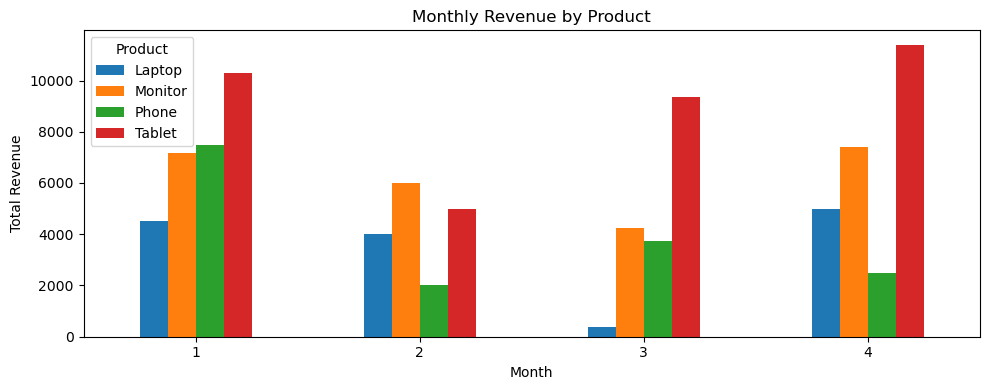

In [300]:
# Group by month and product to calculate total revenue
monthly_revenue = orders_full.groupby(['month', 'product'])['total_price'].sum().unstack(fill_value=0)
monthly_revenue.plot(kind='bar', figsize=(10, 4))
plt.title('Monthly Revenue by Product')
plt.xlabel('Month')
plt.ylabel('Total Revenue')
plt.xticks(rotation=0)
plt.legend(title='Product')
plt.tight_layout()
plt.show()

#### *Visualization: Monthly Revenue by Product*
*This bar chart illustrates the total revenue generated by each product for every month, based on the `total_price` column.*
*Using a grouped bar chart allows for easy comparison across products and months, helping identify patterns such as best-selling months or product performance trends.* 


In [301]:
#Check for the  after all transformations
orders_full.info()
# Save the fully transformed dataset to CSV
orders_full.to_csv('transformed/transformed_full.csv', index=False)


<class 'pandas.core.frame.DataFrame'>
Index: 91 entries, 0 to 99
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   order_id          91 non-null     object        
 1   customer_name     91 non-null     object        
 2   product           91 non-null     category      
 3   quantity          91 non-null     Int64         
 4   unit_price        91 non-null     float64       
 5   order_date        91 non-null     datetime64[ns]
 6   region            91 non-null     category      
 7   month             91 non-null     int32         
 8   total_price       91 non-null     Float64       
 9   revenue_category  91 non-null     category      
dtypes: Float64(1), Int64(1), category(3), datetime64[ns](1), float64(1), int32(1), object(2)
memory usage: 6.4+ KB


# *Transorm-incremental*

In [302]:
# Load incremental data
orders_incremental = pd.read_csv('data/incremental_data.csv')

## 1.*Data cleanning*

In [303]:
orders_incremental .info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   order_id       10 non-null     int64  
 1   customer_name  4 non-null      object 
 2   product        10 non-null     object 
 3   quantity       6 non-null      float64
 4   unit_price     10 non-null     float64
 5   order_date     10 non-null     object 
 6   region         8 non-null      object 
dtypes: float64(2), int64(1), object(4)
memory usage: 692.0+ bytes


### *Remove duplicates*

In [304]:
orders_incremental.duplicated().sum()

0

####  *Handle missing values*

In [305]:
# Fill missing customer_name 'Unknown'
orders_incremental['customer_name'] = orders_incremental['customer_name'].fillna('Unknown')

In [306]:
# Fill missing region with 'Not Specified'
orders_incremental['region'] = orders_incremental['region'].fillna('Not Specified')

In [307]:
# Drop rows where both quantity and unit_price are missing
orders_incremental = orders_incremental.dropna(subset=['quantity', 'unit_price','region'], how='all')
# Convert order_date to datetime and extract month
orders_incremental['order_date'] = pd.to_datetime(orders_incremental['order_date'])
orders_incremental['month'] = orders_incremental['order_date'].dt.month


In [312]:
# Fill remaining missing quantity by (product, month)
orders_incremental['quantity'] = orders_incremental.groupby(['product', 'month'])['quantity'].transform(
    lambda x: x.fillna(x.median()))


# Then fallback to (product) only
orders_incremental['quantity'] = orders_incremental.groupby(['product'])['quantity'].transform(
    lambda x: x.fillna(x.median()))
orders_incremental = orders_incremental.dropna(subset=['quantity'])
orders_incremental.info()


<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 0 to 8
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   order_id       9 non-null      int64         
 1   customer_name  9 non-null      object        
 2   product        9 non-null      object        
 3   quantity       9 non-null      float64       
 4   unit_price     9 non-null      float64       
 5   order_date     9 non-null      datetime64[ns]
 6   region         9 non-null      object        
 7   month          9 non-null      int32         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(1), object(3)
memory usage: 612.0+ bytes
